In [1]:
#import multiprocessing
import LibAu as la
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import h5py as h5
import warnings
warnings.filterwarnings('ignore')

In [2]:
km2kpc=3.24078e-17
def AngMom(dat):#rxv
    #print(dat.shape)
    dat[:,3]=dat[:,3]*km2kpc
    dat[:,4]=dat[:,4]*km2kpc
    dat[:,5]=dat[:,5]*km2kpc
    rxv = np.cross(dat[:,:3],dat[:,3:6])* dat[:,6].reshape((dat[:,6].size,1))
    #Li = (dat[:,1]*dat[:,5] - dat[:,2]*dat[:,4]) * dat[:,6]
    #Lj = (dat[:,2]*dat[:,3] - dat[:,0]*dat[:,5]) * dat[:,6]
    #Lk = (dat[:,0]*dat[:,4] - dat[:,1]*dat[:,3]) * dat[:,6]
    #Lx,Ly,Lz = np.sum(Li),np.sum(Lj),np.sum(Lk)
    return np.sum(rxv,axis=0)#np.array([Lx,Ly,Lz])

In [3]:
la.L3MHDsam

[16, 21, 23, 24, 27, 6]

Au-16 snapshot 60
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  29509636 29517119
Lambda_stars:  0.000	0.010	0.150
Lambda_gas:  -0.020	0.073	0.463
Lambda_dm:  -0.024	0.036	0.050


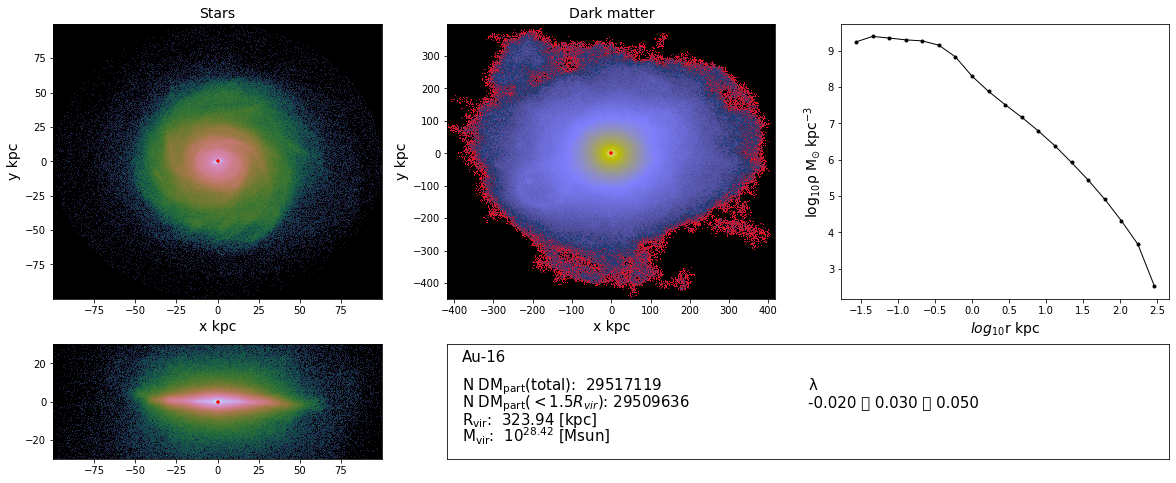

Au-16 snapshot 61
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  29831826 29835630
Lambda_stars:  0.003	0.007	0.156
Lambda_gas:  -0.024	0.075	0.497
Lambda_dm:  -0.024	0.037	0.053


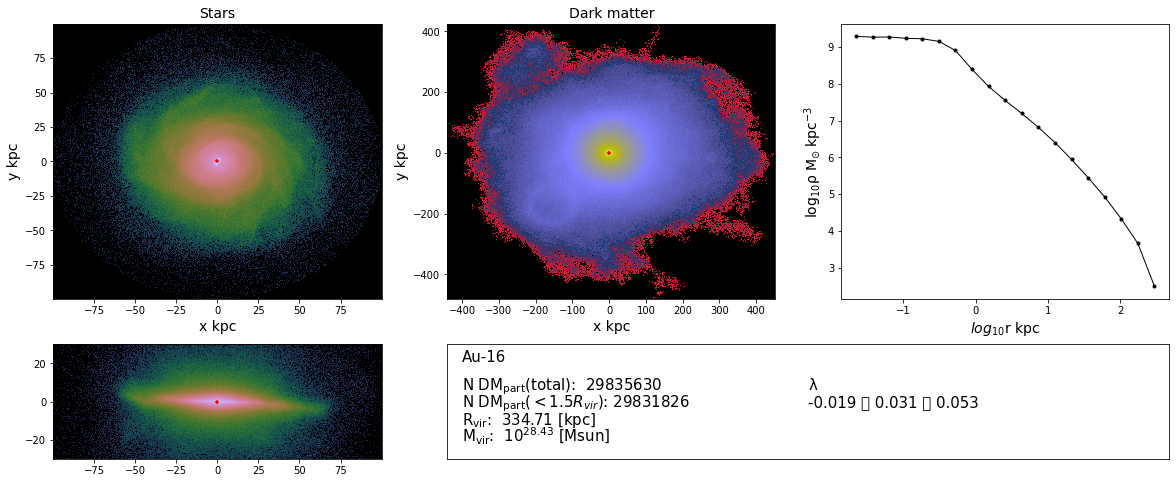

Au-16 snapshot 62
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  30050059 30055432
Lambda_stars:  -0.003	0.001	0.162
Lambda_gas:  -0.056	0.067	0.535
Lambda_dm:  -0.024	0.037	0.054


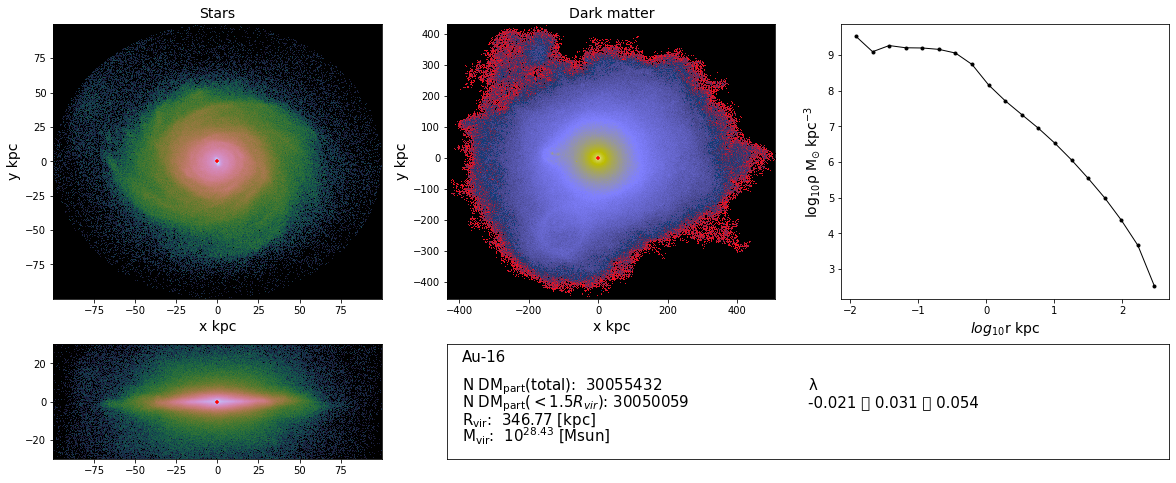

Au-16 snapshot 63
/virgotng/mpa/Auriga/level3/Original/halo_16/output/
DM particles:  30330070 30334251
Lambda_stars:  -0.009	0.006	0.167
Lambda_gas:  -0.091	0.088	0.564
Lambda_dm:  -0.026	0.039	0.052


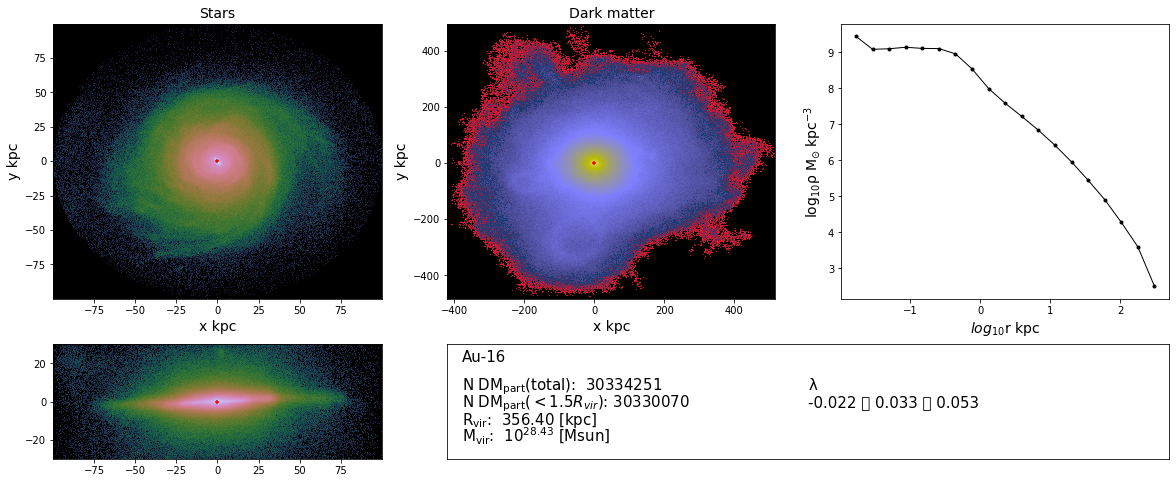

In [4]:
nhalo = 16
Lsnap = np.arange(60,64,1,dtype=int)

#for nhalo in la.L3MHDsam:
for ns in Lsnap:
    
    print('Au-%s snapshot %s'%(nhalo,ns))
    nsnap= 63
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    #def func1(st,f): return sim.Snapshot_Subhalo(idSubhalo=0,snapType=st,fields=f)
    fields_stars = ['pos','vel','id','mass','type','pot','age']
    fields_dm = ['pos','vel','id','mass','type','pot']
    fields_gas = ['pos','vel','id','mass','type','pot']
    #manager = multiprocessing.Manager()
    #return_dict = manager.dict()
    
    #p1 = multiprocessing.Process(target=func1, args=('stars',fields_stars))
    #p2 = multiprocessing.Process(target=func1, args=('dm1',fields_dm))
    #p1.start()
    #p2.start()
    #p1.join()
    #p2.join()
    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
    Datgas = sim.Snapshot_Subhalo(idSubhalo=0,snapType='gas',fields=fields_gas)
    #print(return_dict.values())
    #break
    #del p1,p2
    
    Data = {'stars':Datstars,'dm1':DatDM,'gas':Datgas}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    
    gal = la.ToolRot(Data=Data, param=param)
    Data = gal.Rotate()
    Datstars=Data['stars']
    DatDM = Data['dm1']
    Datgas = Data['gas']
    
    
    # Stellar Parameter -------------------------------
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    
    rs = np.sqrt(Xs**2 + Ys**2)
    rstar = np.sqrt(Xs**2 + Ys**2 +Zs**2)
    
    # DM paramater ------------------------------------
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    rdm= np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    # --------------------------------------------------
    
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    print('DM particles: ',len(r3dm),Npartbe)
    #------------------------------------------------------------------------
    #Compute Lambda
    G= 6.674*1e-11 #m3⋅kg−1⋅s−2
    m2kpc, kg2Msun = 3.2408*1e-20,5e-31
    G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
    
    rgas = np.sqrt(Datgas['pos'][:,0]**2 + Datgas['pos'][:,1]**2 + Datgas['pos'][:,2]**2)
    r200 = Rvir
    sels,selg,seld = (rstar<=r200) , (rgas<=r200) , (rdm<=r200)
    Mencs,Mencg,Mencd=np.sum(Datstars['mass'][sels]), np.sum(Datgas['mass'][selg]), np.sum(DatDM['mass'][seld])
    Menc =  Mencs+Mencg+Mencd
    #print(mass200encl,m200)
    #r X v
    Jstar = AngMom(np.hstack((Datstars['pos'],Datstars['vel'],Datstars['mass'].reshape(Datstars['mass'].size,1)))[sels])
    Jgas  = AngMom(np.hstack((Datgas['pos'],Datgas['vel'],Datgas['mass'].reshape(Datgas['mass'].size,1)))[selg])
    Jdm   = AngMom(np.hstack((DatDM['pos'],DatDM['vel'],DatDM['mass'].reshape(DatDM['mass'].size,1)))[seld])
    ## revisar calculo de J para dm

    J = Jstar+Jgas+Jdm

    #print(Jstar,Jgas,Jdm,J)
    V200 = np.sqrt((G*Menc)/r200)
    V200s,V200g,V200d = np.sqrt((G*Mencs)/r200),np.sqrt((G*Mencg)/r200),np.sqrt((G*Mencd)/r200)
    Lambda = J / (np.sqrt(2)*Menc*r200*V200)
    Ls = Jstar / (np.sqrt(2)*Mencs*r200*V200s)
    Lg = Jgas / (np.sqrt(2)*Mencg*r200*V200g)
    Ld = Jdm / (np.sqrt(2)*Mencd*r200*V200d)
    
    print('Lambda_stars:  %.3f\t%.3f\t%.3f'%(Ls[0],Ls[1],Ls[2]))
    print('Lambda_gas:  %.3f\t%.3f\t%.3f'%(Lg[0],Lg[1],Lg[2]))
    print('Lambda_dm:  %.3f\t%.3f\t%.3f'%(Ld[0],Ld[1],Ld[2]))
    #------------------------------------------------------------------------
    Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
    
    


    plt.figure(figsize=(20,8))
    
    ax1=plt.subplot(3,3,(1,4))
    ax1.patch.set_facecolor('black')
    extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
    plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')
    #plt.title('Au-%s'%nhalo,fontsize=14)
    plt.title('Stars',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    ax2=plt.subplot(3,3,7)
    ax2.patch.set_facecolor('black')
    extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
    plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=20,c='r',marker='+')

    ax3=plt.subplot(3,3,(2,5))
    ax3.patch.set_facecolor('black')
    extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
    plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
    plt.scatter(0,0,s=10,c='r',marker='+')
    plt.title('Dark matter',fontsize=14)
    plt.xlabel('x kpc',fontsize=14)
    plt.ylabel('y kpc',fontsize=14)
    
    plt.subplot(3,3,(3,6))
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)

    plt.plot(DR[:-1],np.log10(rho),lw=1,marker='.',c='k')
    plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
    #print(DR,rho)
    
    plt.subplot(3,3,(8,9))

    plt.text(0.02,0.85,'Au-%s'%nhalo,fontsize=15)
    plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%Npartbe,fontsize=15)
    plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%len(r3dm),fontsize=15)
    plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%Rvir,fontsize=15)
    plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%.2f}$ [Msun]'%np.log(Mvir),fontsize=15)
    plt.text(0.5,0.6,r'$\rm \lambda$',fontsize=15)
    plt.text(0.5,0.45,'%.3f \t %.3f \t %.3f'%(Lambda[0],Lambda[1],Lambda[2]),fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=0.4)
    plt.savefig('plots/profiles_Au%s.pdf'%nhalo)
    plt.show()
    plt.close()
    '''
    #g1 = hf.create_group('Au-%s'%nhalo)
    hf = h5.File('Table/Data_DM_Au-%s.hdf5'%nhalo,'w')
    hf.create_dataset('x'    ,data=Xdm)
    hf.create_dataset('y'    ,data=Ydm)
    hf.create_dataset('z'    ,data=Zdm)
    hf.create_dataset('m'    ,data=Mdm)
    
    hf.close()'''

    

[63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40
 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16
 15 14 13 12 11 10]
Au-16 snapshot 63 number 0
Nstar  14461451
Au-16 snapshot 62 number 1
Nstar  14367723
Au-16 snapshot 61 number 2
Nstar  14239899
Au-16 snapshot 60 number 3
Nstar  14144866
Au-16 snapshot 59 number 4
Nstar  14003605
Au-16 snapshot 58 number 5
Nstar  13861896
Au-16 snapshot 57 number 6
Nstar  13736193
Au-16 snapshot 56 number 7
Nstar  13564003
Au-16 snapshot 55 number 8
Nstar  13355019
Au-16 snapshot 54 number 9
Nstar  13141755
Au-16 snapshot 53 number 10
Nstar  12902038
Au-16 snapshot 52 number 11
Nstar  12619323
Au-16 snapshot 51 number 12
Nstar  12329044
Au-16 snapshot 50 number 13
Nstar  12031658
Au-16 snapshot 49 number 14
Nstar  11600517
Au-16 snapshot 48 number 15
Nstar  11228788
Au-16 snapshot 47 number 16
Nstar  10805294
Au-16 snapshot 46 number 17
Nstar  10316110
Au-16 snapshot 45 number 18
Nstar  9811419
Au-16 sna

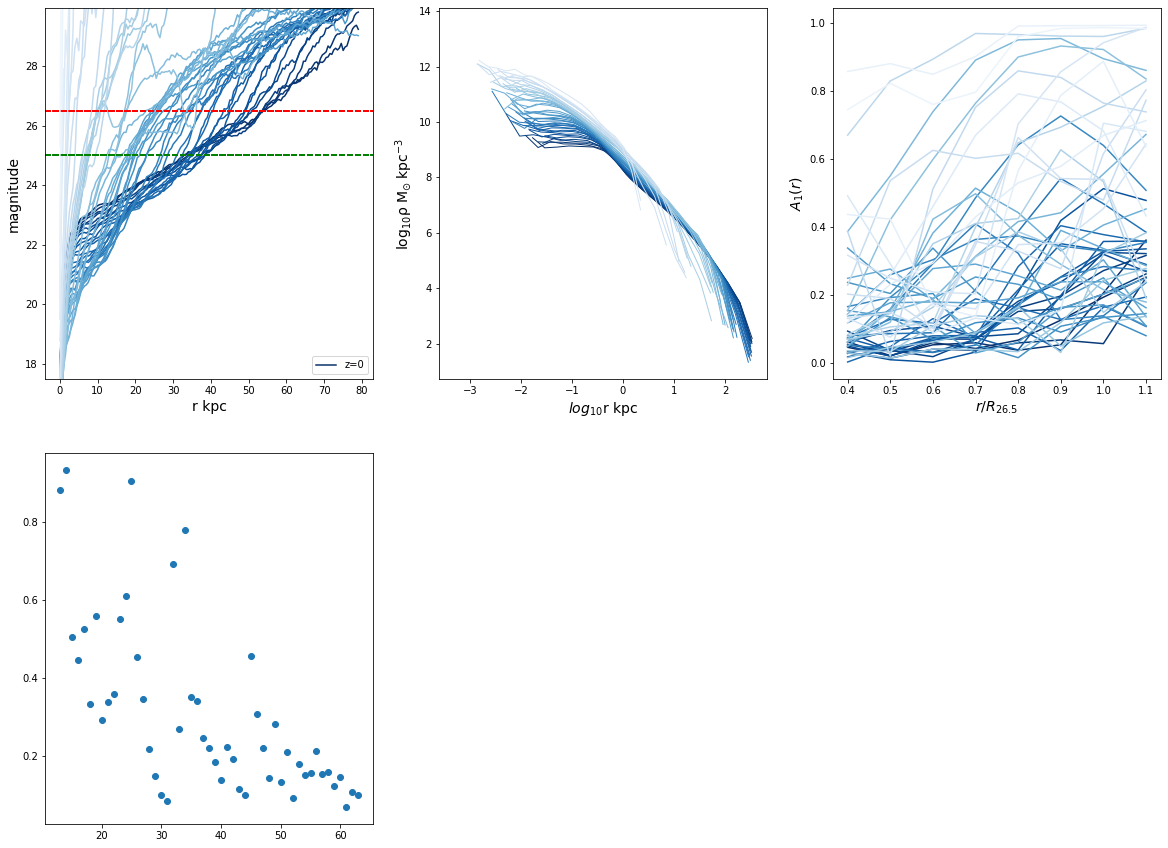

Au-21 snapshot 63 number 0
Nstar  19107866
Au-21 snapshot 62 number 1
Nstar  18881010
Au-21 snapshot 61 number 2
Nstar  18673146
Au-21 snapshot 60 number 3
Nstar  17917181
Au-21 snapshot 59 number 4
Nstar  17425508
Au-21 snapshot 58 number 5
Nstar  17169554
Au-21 snapshot 57 number 6
Nstar  16568654
Au-21 snapshot 56 number 7
Nstar  16299975
Au-21 snapshot 55 number 8
Nstar  16003094
Au-21 snapshot 54 number 9
Nstar  15645917
Au-21 snapshot 53 number 10
Nstar  15377056
Au-21 snapshot 52 number 11
Nstar  14868261
Au-21 snapshot 51 number 12
Nstar  14465888
Au-21 snapshot 50 number 13
Nstar  14046797
Au-21 snapshot 49 number 14
Nstar  13437906
Au-21 snapshot 48 number 15
Nstar  12867808
Au-21 snapshot 47 number 16
Nstar  12230787
Au-21 snapshot 46 number 17
Nstar  11500446
Au-21 snapshot 45 number 18
Nstar  10734274
Au-21 snapshot 44 number 19
Nstar  10094435
Au-21 snapshot 43 number 20
Nstar  9265687
Au-21 snapshot 42 number 21
Nstar  8591289
Au-21 snapshot 41 number 22
Nstar  8123762
A

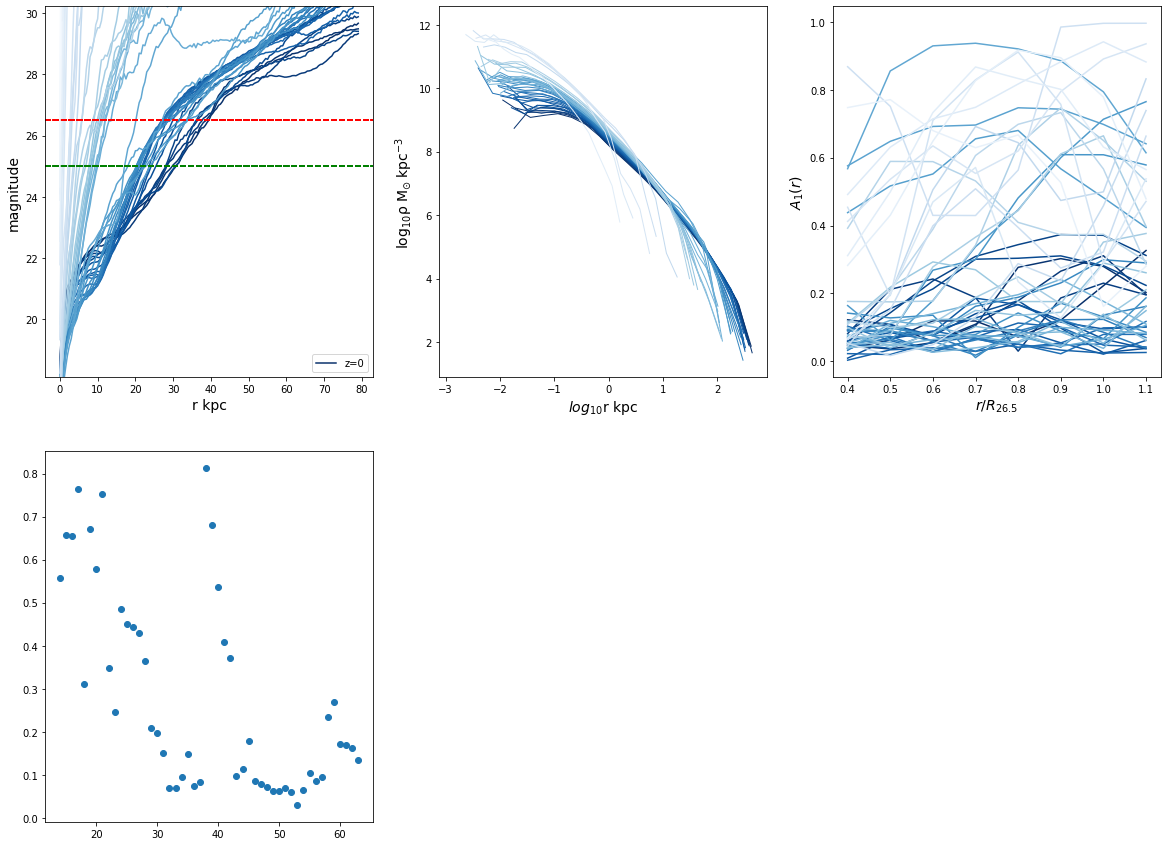

Au-23 snapshot 63 number 0
Nstar  18224697
Au-23 snapshot 62 number 1
Nstar  18033232
Au-23 snapshot 61 number 2
Nstar  17812897
Au-23 snapshot 60 number 3
Nstar  17560679
Au-23 snapshot 59 number 4
Nstar  17304258
Au-23 snapshot 58 number 5
Nstar  17025707
Au-23 snapshot 57 number 6
Nstar  16705942
Au-23 snapshot 56 number 7
Nstar  16365679
Au-23 snapshot 55 number 8
Nstar  15925332
Au-23 snapshot 54 number 9
Nstar  15469216
Au-23 snapshot 53 number 10
Nstar  14865549
Au-23 snapshot 52 number 11
Nstar  14362194
Au-23 snapshot 51 number 12
Nstar  13332188
Au-23 snapshot 50 number 13
Nstar  13007911
Au-23 snapshot 49 number 14
Nstar  12702537
Au-23 snapshot 48 number 15
Nstar  12474255
Au-23 snapshot 47 number 16
Nstar  12283875
Au-23 snapshot 46 number 17
Nstar  12112392
Au-23 snapshot 45 number 18
Nstar  11872575
Au-23 snapshot 44 number 19
Nstar  11528653
Au-23 snapshot 43 number 20
Nstar  11221411
Au-23 snapshot 42 number 21
Nstar  10920477
Au-23 snapshot 41 number 22
Nstar  1062531

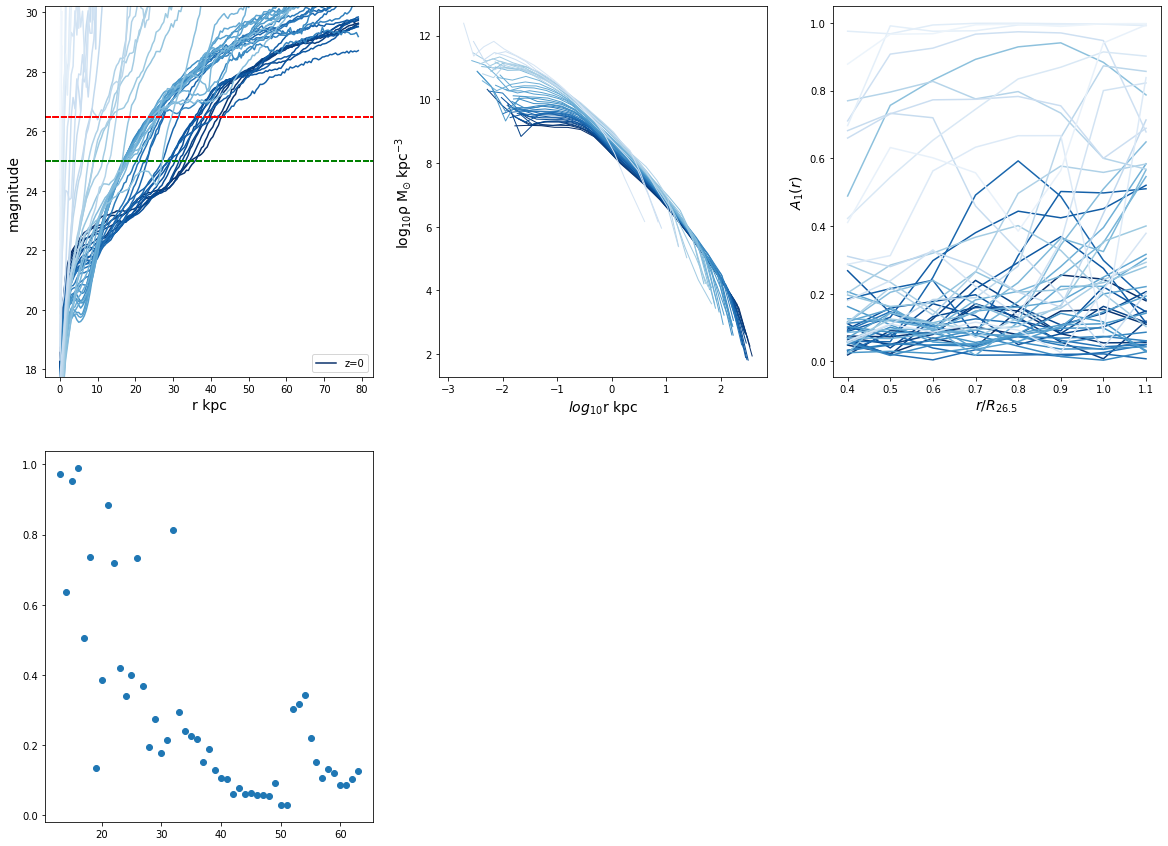

Au-24 snapshot 63 number 0
Nstar  20045362
Au-24 snapshot 62 number 1
Nstar  19894870
Au-24 snapshot 61 number 2
Nstar  19703059
Au-24 snapshot 60 number 3
Nstar  19503818
Au-24 snapshot 59 number 4
Nstar  19285088
Au-24 snapshot 58 number 5
Nstar  19053785
Au-24 snapshot 57 number 6
Nstar  18803410
Au-24 snapshot 56 number 7
Nstar  18556069
Au-24 snapshot 55 number 8
Nstar  17901318
Au-24 snapshot 54 number 9
Nstar  17455675
Au-24 snapshot 53 number 10
Nstar  17037477
Au-24 snapshot 52 number 11
Nstar  16453495
Au-24 snapshot 51 number 12
Nstar  16001623
Au-24 snapshot 50 number 13
Nstar  15626521
Au-24 snapshot 49 number 14
Nstar  15054970
Au-24 snapshot 48 number 15
Nstar  14631039
Au-24 snapshot 47 number 16
Nstar  14168984
Au-24 snapshot 46 number 17
Nstar  13539336
Au-24 snapshot 45 number 18
Nstar  12895863
Au-24 snapshot 44 number 19
Nstar  12278746
Au-24 snapshot 43 number 20
Nstar  11617076
Au-24 snapshot 42 number 21
Nstar  10877294
Au-24 snapshot 41 number 22
Nstar  1012761

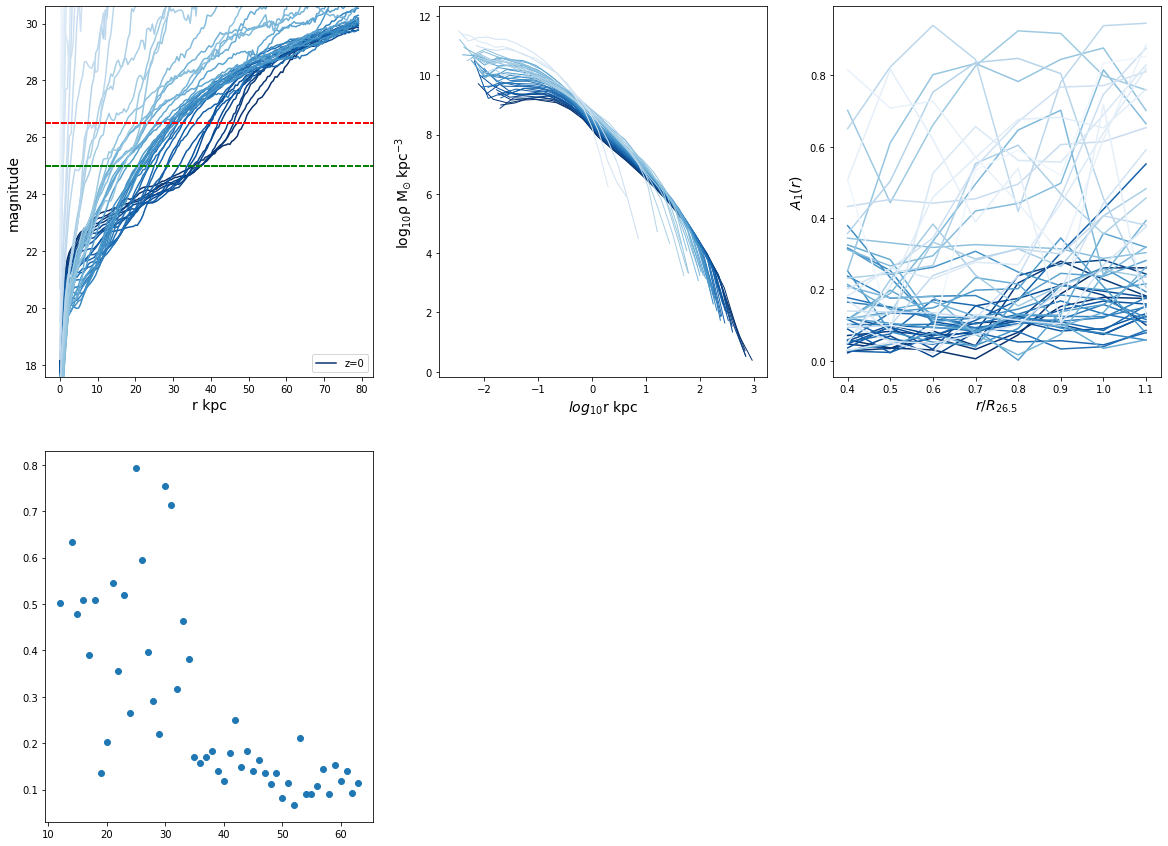

Au-27 snapshot 63 number 0
Nstar  21645312
Au-27 snapshot 62 number 1
Nstar  21471524
Au-27 snapshot 61 number 2
Nstar  21274039
Au-27 snapshot 60 number 3
Nstar  21049076
Au-27 snapshot 59 number 4
Nstar  20843450
Au-27 snapshot 58 number 5
Nstar  20597448
Au-27 snapshot 57 number 6
Nstar  20282331
Au-27 snapshot 56 number 7
Nstar  19885233
Au-27 snapshot 55 number 8
Nstar  19476127
Au-27 snapshot 54 number 9
Nstar  19005486
Au-27 snapshot 53 number 10
Nstar  18608584
Au-27 snapshot 52 number 11
Nstar  18130997
Au-27 snapshot 51 number 12
Nstar  17573924
Au-27 snapshot 50 number 13
Nstar  17168172
Au-27 snapshot 49 number 14
Nstar  16797115
Au-27 snapshot 48 number 15
Nstar  16377430
Au-27 snapshot 47 number 16
Nstar  15891566
Au-27 snapshot 46 number 17
Nstar  15410943
Au-27 snapshot 45 number 18
Nstar  14974852
Au-27 snapshot 44 number 19
Nstar  14614075
Au-27 snapshot 43 number 20
Nstar  13970389
Au-27 snapshot 42 number 21
Nstar  13238367
Au-27 snapshot 41 number 22
Nstar  1252616

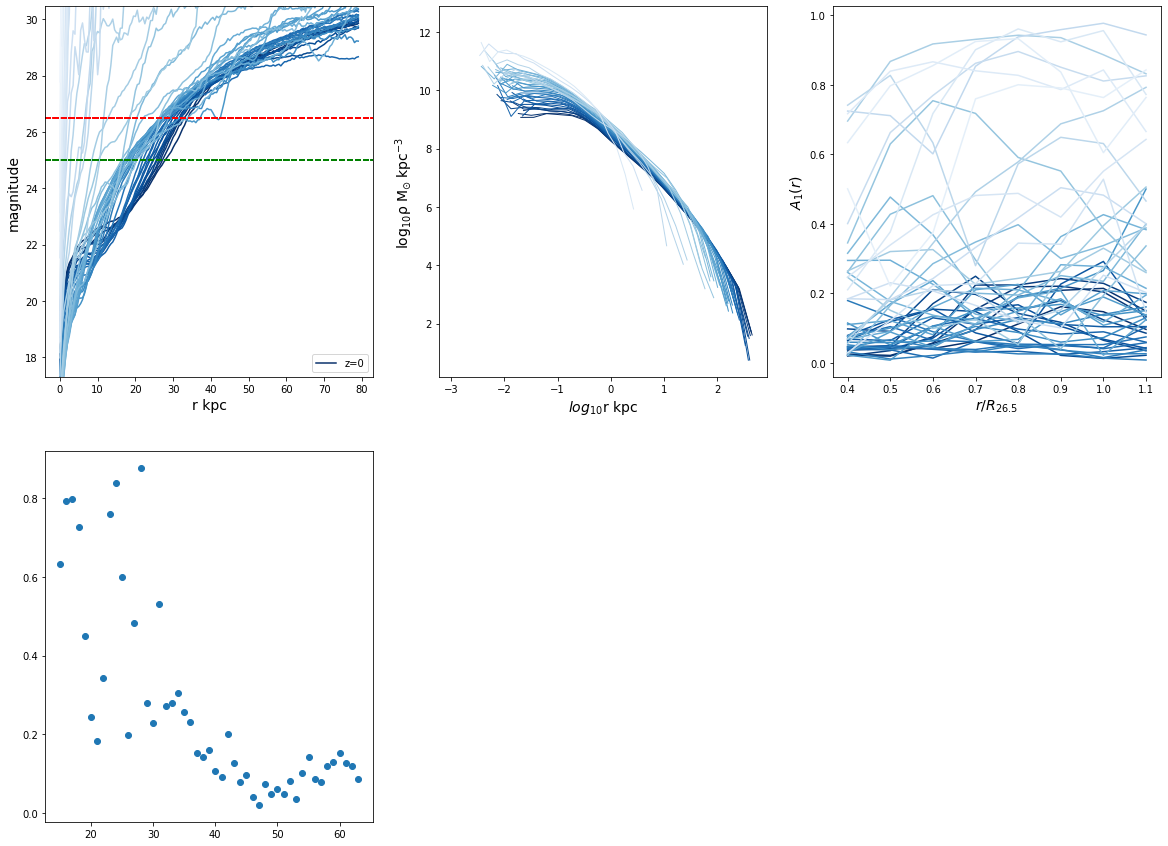

Au-6 snapshot 63 number 0
Nstar  15542606
Au-6 snapshot 62 number 1
Nstar  15442148
Au-6 snapshot 61 number 2
Nstar  15351571
Au-6 snapshot 60 number 3
Nstar  15259649
Au-6 snapshot 59 number 4
Nstar  15170489
Au-6 snapshot 58 number 5
Nstar  15084143
Au-6 snapshot 57 number 6
Nstar  14964050
Au-6 snapshot 56 number 7
Nstar  14857102
Au-6 snapshot 55 number 8
Nstar  14689809
Au-6 snapshot 54 number 9
Nstar  14485306
Au-6 snapshot 53 number 10
Nstar  14318279
Au-6 snapshot 52 number 11
Nstar  14093617
Au-6 snapshot 51 number 12
Nstar  13888266
Au-6 snapshot 50 number 13
Nstar  13637798
Au-6 snapshot 49 number 14
Nstar  13172020
Au-6 snapshot 48 number 15
Nstar  12523723
Au-6 snapshot 47 number 16
Nstar  12199404
Au-6 snapshot 46 number 17
Nstar  11904150
Au-6 snapshot 45 number 18
Nstar  11209563
Au-6 snapshot 44 number 19
Nstar  10382702
Au-6 snapshot 43 number 20
Nstar  9758602
Au-6 snapshot 42 number 21
Nstar  9234702
Au-6 snapshot 41 number 22
Nstar  8244123
Au-6 snapshot 40 number 

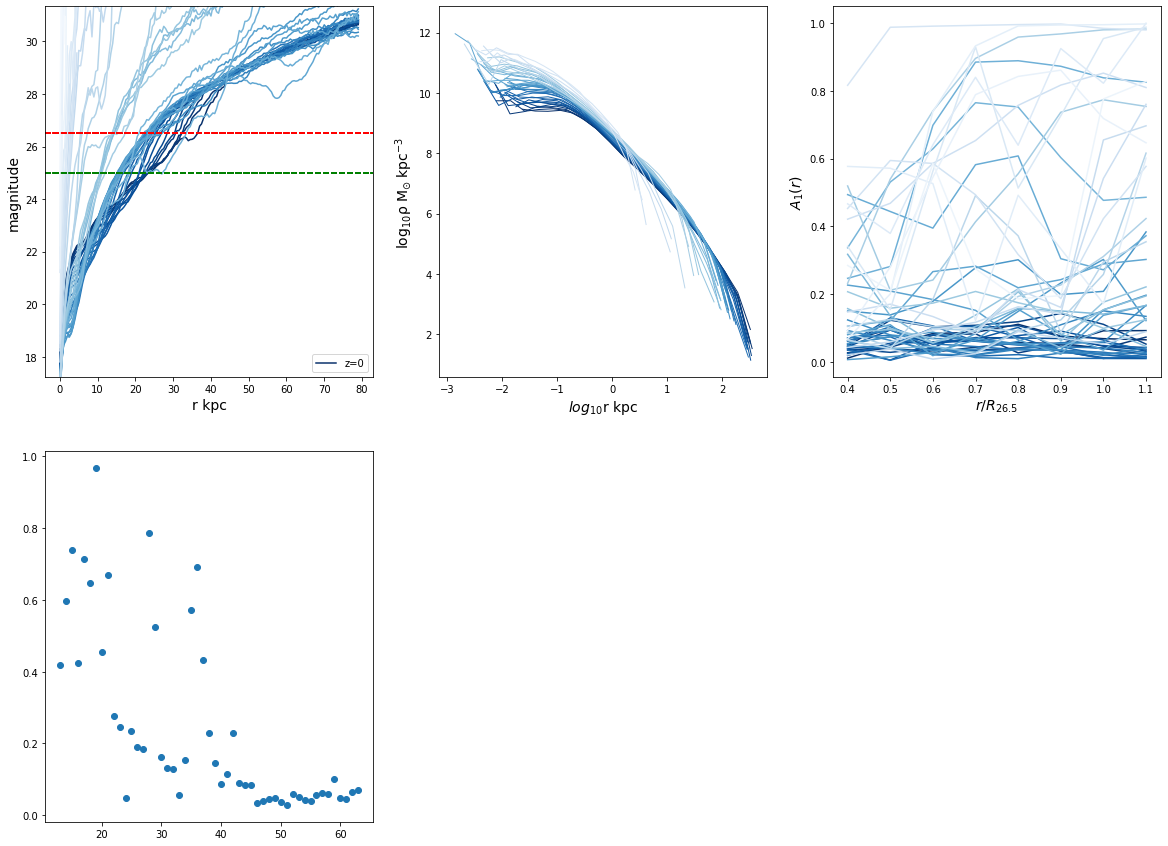

In [5]:
import matplotlib.pylab as pl
#nhalo = 16
Lsnap = np.arange(10,64,1,dtype=int)[::-1]
print(Lsnap)

#plt.subplots_adjust(hspace=0.4)

for nhalo in la.L3MHDsam:
  colors = pl.cm.Blues(np.linspace(0,1,len(Lsnap)))[::-1]

  plt.figure(figsize=(20,15))
  ax1=plt.subplot(2,3,1)
  ax2=plt.subplot(2,3,2)
  ax3=plt.subplot(2,3,3)
  ax4=plt.subplot(2,3,4)
  #if nhalo!=16:continue
  #print('halo ID ',nhalo)
  A1Med=[]
  
  for ii,ns in enumerate(Lsnap):
    
    print('Au-%s snapshot %s number %s'%(nhalo,ns,ii))
    #print(colors[ii])
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    
    Rvir =sim.sf.data['frc2'][0]*1000*sc/h #[kpc] 
    Mvir =sim.sf.data['fmc2'][0]*1e10/h    #[Msun]
    
    fields_stars = ['pos','vel','id','mass','type','pot','age','gsph']
    fields_dm = ['pos','vel','id','mass','type','pot']

    

    Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)
    DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)

    #print('edad ',len(Datstars['age']),max(Datstars['age']),min(Datstars['age']))
    Data = {'stars':Datstars,'dm1':DatDM}
    param = {'spos':sim.sf.data['spos'][0,:],
            'svel':sim.sf.data['svel'][0,:],
            'header':sim.Header()}
    #print('rotar')
    nans = np.isnan(Datstars['age'])
    agelimit = np.percentile(Datstars['age'][~nans],25)
    
    gal = la.ToolRot(Data=Data, param=param,agelim=agelimit  )
    Data = gal.Rotate()
    Datstars=Data['stars']
    DatDM = Data['dm1']
    #print('fin rotar')
    
    
    # Stellar Parameter ==============================================
    poss = Datstars['pos']#[kpc]
    Xs = poss[:,0] 
    Ys = poss[:,1]
    Zs = poss[:,2]
    Ms = Datstars['mass'] #[Msun]
    photpart = Datstars['gsph']
    rs = np.sqrt(Xs**2 + Ys**2)
    rstar = np.sqrt(Xs**2 + Ys**2 +Zs**2)
    print('Nstar ',len(rstar))
    #----------SB profile
    rsd,mvs = la.StellarDensity1D(rs,photpart[:,2],lmax=80)
    if ns==63: ax1.plot(rsd,mvs,color=colors[ii],label='z=0')
    else:ax1.plot(rsd,mvs,color=colors[ii])
    ax1.axhline(26.5,ls='--',c='r')
    ax1.axhline(25,ls='--',c='g')
    yl=ax1.get_ylim()
    ax1.set_ylim(yl[::-1])
    ax1.set_xlabel(r'r kpc',fontsize=14)
    ax1.set_ylabel(r'magnitude',fontsize=14)
    ax1.legend()
    
    #----------optical radius
    ropt = la.Ropts(rsd,mvs,mag=25)
    rholm = la.Ropts(rsd,mvs,mag=26.5)
    #----------MFourier A1
    fstar=np.array([Xs,Ys,Zs,Xs,Ys,Zs,Ms])
    Subhalo0= la.Asymmetry(stars_data=fstar.T,dm_data=None)
    #fstar: [x,y,z,vx,vy,vz,m,age,idstar,Metal,U,B,V,K,g,r,i,z_]
    median_A1,distr_A1 = Subhalo0.Mfourier(Ropt=rholm,r_min=0.4,r_max=1.2,r_int=0.1)

    ax3.plot(distr_A1[0],distr_A1[1],color=colors[ii])
    ax3.set_xlabel(r'$r/R_{26.5}$',fontsize=14)
    ax3.set_ylabel(r'$A_1(r)$',fontsize=14)
    #ax3.set_ylim(0,0.2)
    A1Med.append(median_A1)
    del fstar
    # DM paramater ==============================================
    posdm = DatDM['pos'] #[kpc
    Xdm = posdm[:,0]
    Ydm = posdm[:,1]
    Zdm = posdm[:,2]
    Mdm = DatDM['mass'] #[Msun]
    r3dm = np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    rdm= np.sqrt(Xdm**2 + Ydm**2 + Zdm**2)
    Npartbe = len(r3dm)
    
    r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
    r3dml = np.log10(r3dm)
    DR = np.linspace(r3min,r3max,20)
    DRn = 10**DR
    rho = []
    for i,j in enumerate(DR):
        if i==len(DR)-1:continue
        sel = (j<=r3dml)&(r3dml<DR[i+1])
        vol = (4/3)*np.pi*(DRn[i+1]**3 - DRn[i]**3)
        rho.append(np.sum(Mdm[sel])/vol)
        
    ax2.plot(DR[:-1],np.log10(rho),color=colors[ii],lw=1)
    ax2.set_ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
    ax2.set_xlabel(r'$log_{10}$r kpc',fontsize=14)
    # --------------------------------------------------
    
    
    
    '''
    cuts= (rs<=100)& (np.abs(Zs)<=30)
    Xs,Ys,Zs,Ms=Xs[cuts],Ys[cuts],Zs[cuts],Ms[cuts]
    
    cutdm= r3dm<=1.5*Rvir
    Xdm,Ydm,Zdm,Mdm,r3dm=Xdm[cutdm],Ydm[cutdm],Zdm[cutdm],Mdm[cutdm],r3dm[cutdm]
    
    r200 = Rvir
    sels,seld = (rstar<=r200) , (rdm<=r200)'''


    #------------------------------------------------------------------------
    #Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(Xs,Ys,Ms,npix = [720,720],style='SD')
    #Hse,_xse,_yse,boxse = la.StellarDensity2D(Xs,Zs,Ms,npix = [720,int(720/2)],style='SD')

    #Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(Xdm,Ydm,Mdm,npix = [720,720],style='SD')
    
  A1Med=np.array(A1Med)
  ax4.scatter(Lsnap,A1Med)
  plt.show()
  plt.close()
    

In [6]:
for ii,ns in enumerate(Lsnap):
    
    print('Au-%s snapshot %s number %s'%(nhalo,ns,ii))
    #print(colors[ii])
    sim = la.Reader_Au(Nhalo=nhalo,Nsnap=ns)
    #print(sim.base)
    
    header = sim.Header()
    h=header['hubbleparam']
    sc=header['time']
    print(header['redshift'],ns)

Au-6 snapshot 63 number 0
2.220446049250313e-16 63
Au-6 snapshot 62 number 1
0.023974428382762536 62
Au-6 snapshot 61 number 2
0.04852362998180593 61
Au-6 snapshot 60 number 3
0.07366138465643868 60
Au-6 snapshot 59 number 4
0.09940180263022191 59
Au-6 snapshot 58 number 5
0.12575933241126092 58
Au-6 snapshot 57 number 6
0.15274876890238098 57
Au-6 snapshot 56 number 7
0.1803852617057493 56
Au-6 snapshot 55 number 8
0.21442503551449454 55
Au-6 snapshot 54 number 9
0.24354018155467028 54
Au-6 snapshot 53 number 10
0.2733533465784399 53
Au-6 snapshot 52 number 11
0.31007412012783386 52
Au-6 snapshot 51 number 12
0.3478538418581776 51
Au-6 snapshot 50 number 13
0.38016786726023866 50
Au-6 snapshot 49 number 14
0.41996894199726653 49
Au-6 snapshot 48 number 15
0.4609177941806475 48
Au-6 snapshot 47 number 16
0.5030475232448832 47
Au-6 snapshot 46 number 17
0.5463921831410221 46
Au-6 snapshot 45 number 18
0.5985432881875667 45
Au-6 snapshot 44 number 19
0.6446418406845371 44
Au-6 snapshot 4

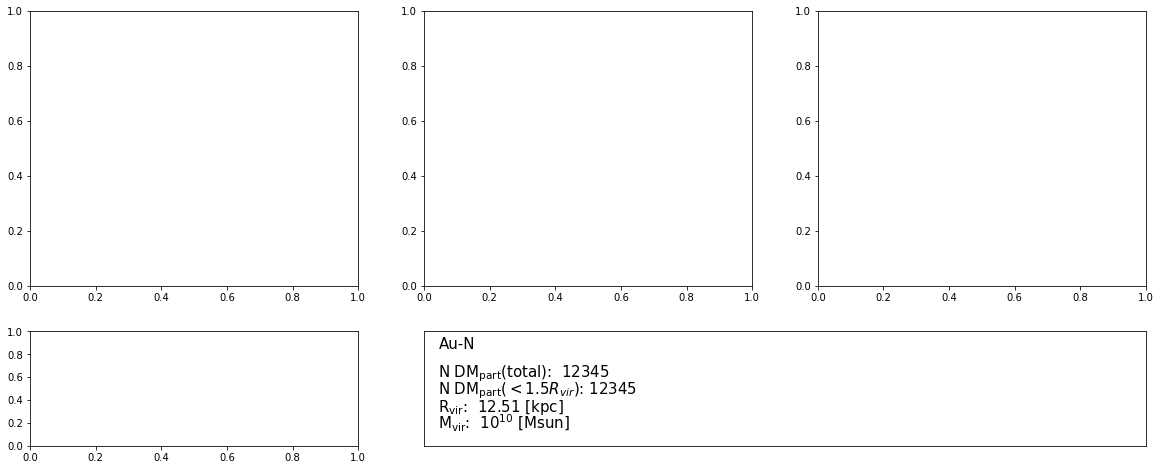

In [7]:
plt.figure(figsize=(20,8))
plt.subplot(3,3,(1,4))

plt.subplot(3,3,7)

plt.subplot(3,3,(2,5))

plt.subplot(3,3,(3,6))

plt.subplot(3,3,(8,9))

plt.text(0.02,0.85,'Au-N',fontsize=15)
plt.text(0.02,0.6,r'N $\rm DM_{part}$(total):  %s'%12345,fontsize=15)
plt.text(0.02,0.45,r'N $\rm DM_{part}$($<1.5R_{vir}$): %s'%12345,fontsize=15)
plt.text(0.02,0.3,r'$\rm R_{vir}$:  %.2f [kpc]'%12.512345,fontsize=15)
plt.text(0.02,0.15,r'$\rm M_{vir}$:  $10^{%s}$ [Msun]'%10,fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()

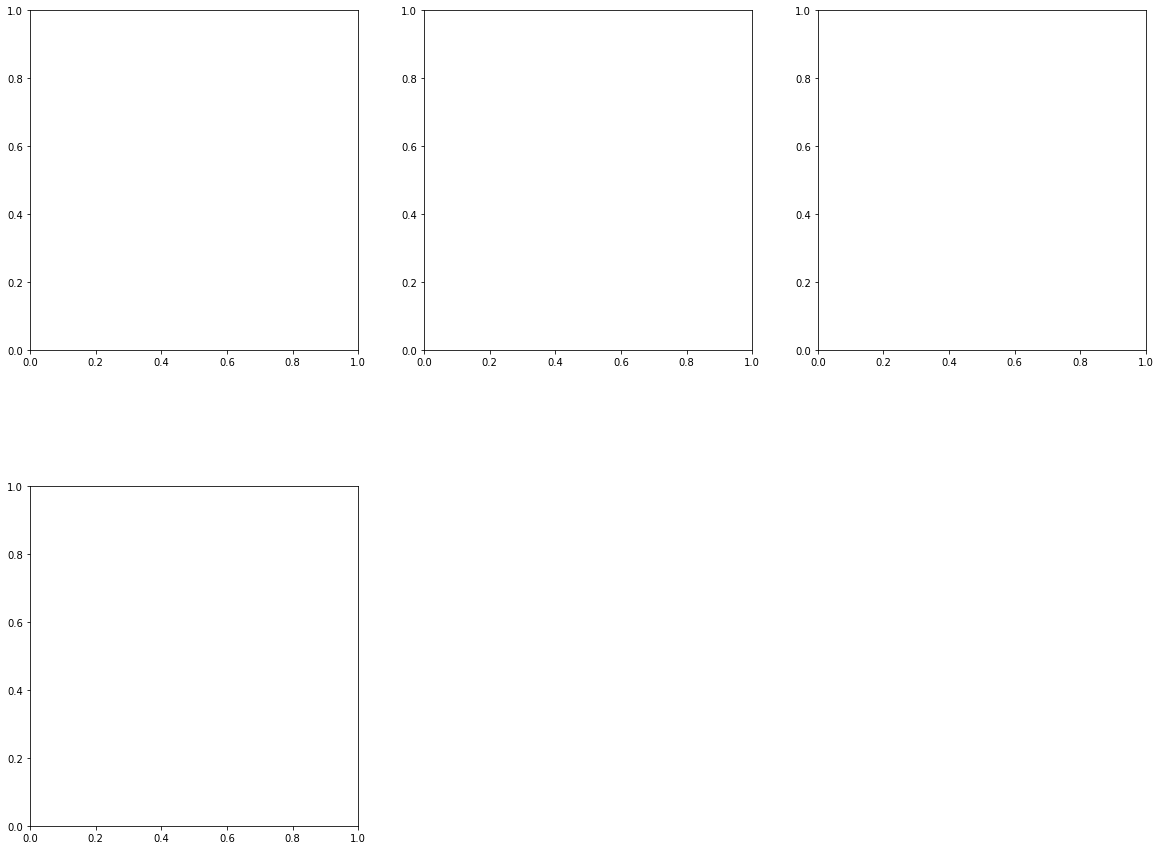

In [8]:
plt.figure(figsize=(20,15))
plt.subplot(2,3,1)

plt.subplot(2,3,2)

plt.subplot(2,3,3)

plt.subplot(2,3,4)



plt.subplots_adjust(hspace=0.4)
plt.show()
plt.close()